In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [2]:
api_key = '6feb8c26f0ebddbc4a47b6cfeac77054'
url = f'https://api.stlouisfed.org/fred/series/observations?series_id=CPALTT01CLM657N&api_key={api_key}&observation_start=1960-01-01&observation_end=2022-12-01&frequency=m&file_type=json'
response = requests.get(url)

In [3]:
json_data = response.json()

In [4]:
data = [(obs["date"], obs["value"]) for obs in json_data["observations"]]
df = pd.DataFrame(data, columns=["date", "Inflation Rate Chile"])
df["date"] = pd.to_datetime(df["date"])
df["Inflation Rate Chile"] = df["Inflation Rate Chile"].astype("float")
df.index = df["date"]
df = df.drop("date", axis = 1)
df.dropna()
df

Inflation Rate Chile
date                            
1970-02-01              5.109489
1970-03-01              3.472222
1970-04-01              2.396932
1970-05-01              2.153558
1970-06-01              1.924840
...                          ...
2022-08-01              1.216173
2022-09-01              0.859394
2022-10-01              0.520710
2022-11-01              0.973236
2022-12-01              0.287602

[635 rows x 1 columns]

In [5]:
plt.figure(figsize=(12, 8))
plt.plot(df['Inflation Rate Chile'])
plt.title("Chile's Inflation Rate")
plt.xlabel('Year')
plt.ylabel('Inflation (Variation in Price Level)')

Text(0, 0.5, 'Inflation (Variation in Price Level)')

In [6]:
len(df)

635

In [7]:
q_80 = int(len(df) * .8)
q_90 = int(len(df) * .9)

In [8]:
y_train = df["Inflation Rate Chile"].iloc[:q_80]
y_val = df["Inflation Rate Chile"].iloc[q_80: q_90]
y_test = df["Inflation Rate Chile"].iloc[q_90:]

In [9]:
y_train.plot(figsize = (12, 8))
y_val.plot()
y_test.plot()

<AxesSubplot:xlabel='date'>

In [10]:
from tensorflow.keras.models import Sequential

In [11]:
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
from tensorflow.keras.optimizers import Adam

In [14]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
length = 18
batch_size = 1

In [16]:
generator = TimeseriesGenerator(y_train, y_train, length = length, batch_size = batch_size)

In [17]:
validation_generator = TimeseriesGenerator(y_val, y_val, length = length, batch_size = batch_size)

In [18]:
test_generator = TimeseriesGenerator(y_test, y_test, length = length, batch_size = batch_size)

In [19]:
es = EarlyStopping(monitor = "val_loss", patience = 5)

In [20]:
n_features = 1

In [21]:
m = Sequential()

m.add(LSTM(64, input_shape = (length, n_features), activation = "relu", return_sequences = False))

m.add(Dense(8, activation = "relu"))

m.add(Dense(1, activation = "linear"))

m.compile(optimizer = Adam(learning_rate = .0001), loss = "mse", metrics = ["mean_absolute_error"])

In [22]:
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [23]:
m.fit_generator(generator, epochs = 50, validation_data = validation_generator, callbacks = [es])

Epoch 1/50


C:\Users\User\AppData\Local\Temp\ipykernel_14736\1446656313.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  m.fit_generator(generator, epochs = 50, validation_data = validation_generator, callbacks = [es])


490/490 [==============================] - 3s 4ms/step - loss: 29.1815 - mean_absolute_error: 2.0291 - val_loss: 0.1453 - val_mean_absolute_error: 0.3073
Epoch 2/50
490/490 [==============================] - 1s 3ms/step - loss: 21.4177 - mean_absolute_error: 1.6307 - val_loss: 0.0921 - val_mean_absolute_error: 0.2294
Epoch 3/50
490/490 [==============================] - 2s 3ms/step - loss: 18.7608 - mean_absolute_error: 1.4139 - val_loss: 0.1137 - val_mean_absolute_error: 0.2677
Epoch 4/50
490/490 [==============================] - 2s 3ms/step - loss: 17.8168 - mean_absolute_error: 1.2571 - val_loss: 0.1335 - val_mean_absolute_error: 0.2953
Epoch 5/50
490/490 [==============================] - 1s 3ms/step - loss: 16.7840 - mean_absolute_error: 1.2281 - val_loss: 0.1134 - val_mean_absolute_error: 0.2646
Epoch 6/50
490/490 [==============================] - 2s 3ms/step - loss: 16.1712 - mean_absolute_error: 1.1830 - val_loss: 0.1279 - val_mean_absolute_error: 0.2845
Epoch 7/50
490/490 [=

<AxesSubplot:>

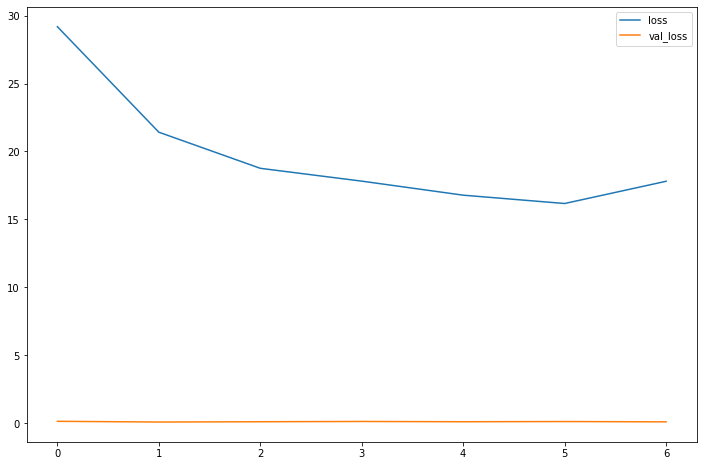

In [24]:
losses = pd.DataFrame(m.history.history)
losses[["loss", "val_loss"]].plot(figsize = (12, 8))

In [25]:
y_hat_train = m.predict(generator).flatten()

490/490 [==============================] - 1s 1ms/step


<AxesSubplot:xlabel='date'>

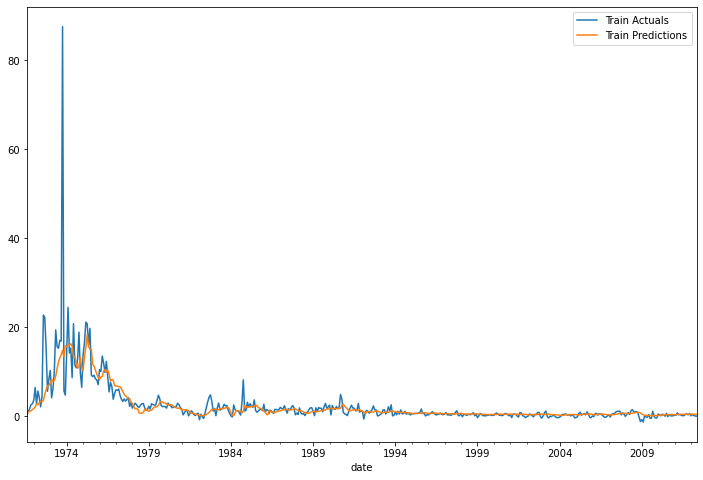

In [26]:
train_df = pd.DataFrame(data = {"Train Actuals": y_train.iloc[length:].values.flatten(), "Train Predictions": y_hat_train}, index = y_train.iloc[length:].index)
train_df.plot(figsize = (12, 8))

<AxesSubplot:xlabel='date'>

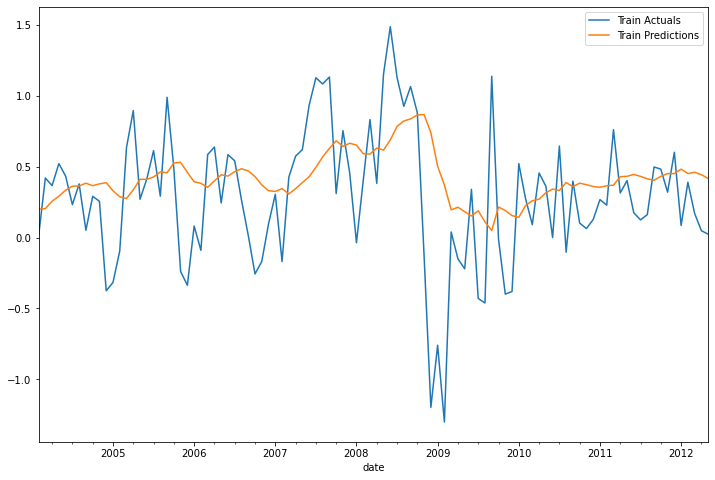

In [27]:
train_df.iloc[-100:].plot(figsize = (12, 8))

In [28]:
y_hat_val = m.predict(validation_generator).flatten()

45/45 [==============================] - 0s 2ms/step


<AxesSubplot:xlabel='date'>

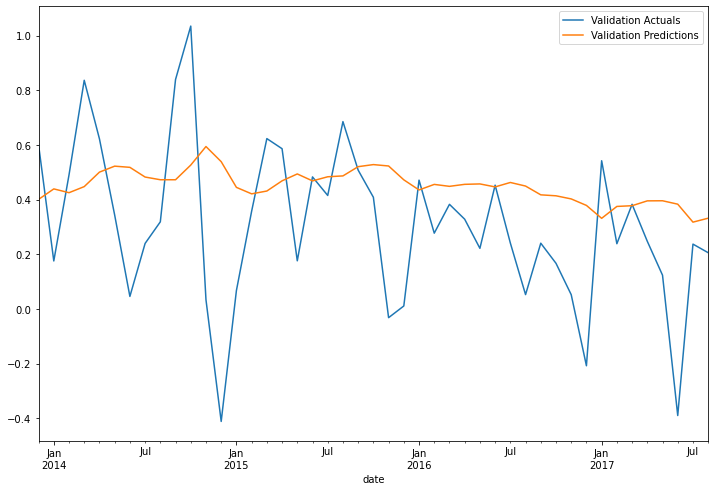

In [29]:
val_df = pd.DataFrame(data = {"Validation Actuals": y_val.iloc[length:].values.flatten(), "Validation Predictions": y_hat_val}, index = y_val.iloc[length:].index)
val_df.plot(figsize = (12, 8))

<AxesSubplot:xlabel='date'>

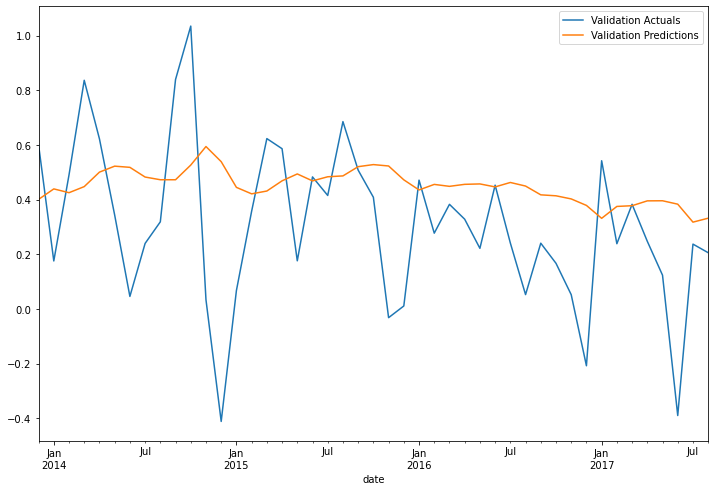

In [30]:
val_df.iloc[-100:].plot(figsize = (12, 8))

In [31]:
y_hat_test = m.predict(test_generator).flatten()

46/46 [==============================] - 0s 1ms/step


<AxesSubplot:xlabel='date'>

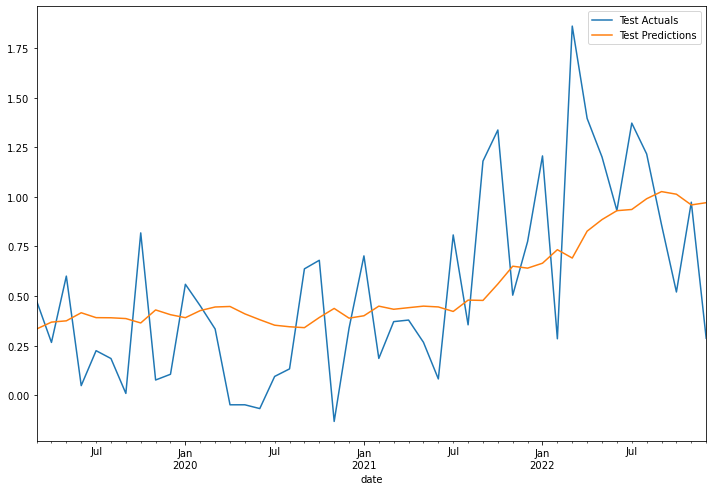

In [32]:
test_df = pd.DataFrame(data = {"Test Actuals": y_test.iloc[length:].values.flatten(), "Test Predictions": y_hat_test}, index = y_test.iloc[length:].index)
test_df.plot(figsize = (12, 8))

<AxesSubplot:xlabel='date'>

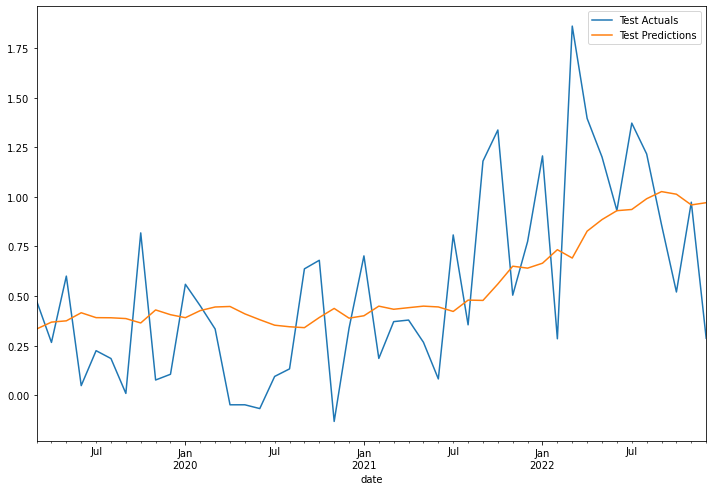

In [33]:
test_df.iloc[-100:].plot(figsize = (12, 8))

In [34]:
ax = train_df.plot(figsize = (12, 8))
val_df.plot(ax = ax)
test_df.plot(ax = ax)

<AxesSubplot:xlabel='date'>

### Forecast

In [35]:
m = Sequential()

m.add(LSTM(64, input_shape = (length, n_features), activation = "relu", return_sequences = False))

m.add(Dense(8, activation = "relu"))

m.add(Dense(1, activation = "linear"))

m.compile(optimizer = Adam(learning_rate = .0001), loss = "mse", metrics = ["mean_absolute_error"])

In [36]:
full_generator = TimeseriesGenerator(df["Inflation Rate Chile"], df["Inflation Rate Chile"], length = length, batch_size = batch_size)

In [37]:
m.fit_generator(full_generator, epochs = es.stopped_epoch)

Epoch 1/6


C:\Users\User\AppData\Local\Temp\ipykernel_14736\3418163387.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  m.fit_generator(full_generator, epochs = es.stopped_epoch)


617/617 [==============================] - 5s 6ms/step - loss: 24.3232 - mean_absolute_error: 1.6528
Epoch 2/6
617/617 [==============================] - 3s 4ms/step - loss: 16.1756 - mean_absolute_error: 1.2332
Epoch 3/6
617/617 [==============================] - 3s 4ms/step - loss: 15.3778 - mean_absolute_error: 1.1373
Epoch 4/6
617/617 [==============================] - 3s 5ms/step - loss: 14.5367 - mean_absolute_error: 1.1113
Epoch 5/6
617/617 [==============================] - 3s 4ms/step - loss: 13.7774 - mean_absolute_error: 1.0581
Epoch 6/6
617/617 [==============================] - 2s 3ms/step - loss: 13.6030 - mean_absolute_error: 1.0823


In [38]:
y_forecast = []

first_eval_batch = df["Inflation Rate Chile"][-length:].values
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    current_pred = m.predict(current_batch)[0]
    y_forecast.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 17ms/step


In [39]:
forecast_index = pd.date_range(start = df.index[-1], periods = length, freq = "MS")

In [40]:
forecast_df = pd.DataFrame(data = y_forecast, index = forecast_index, columns = ["Inflation Rate Chile Forecast"])

<AxesSubplot:xlabel='date'>

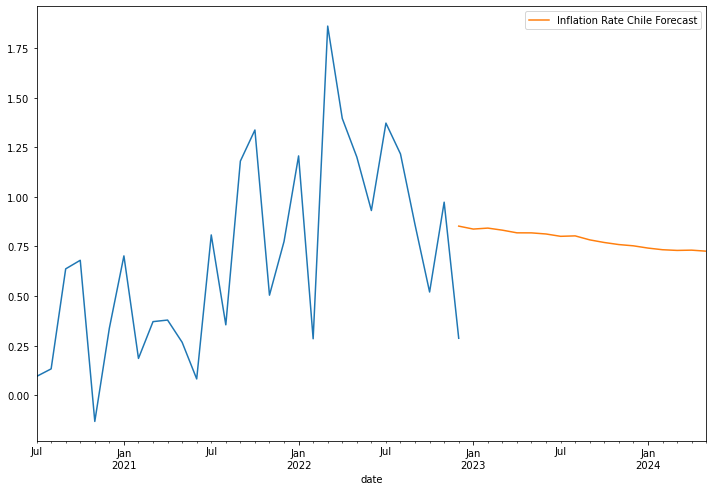

In [45]:
ax = df["Inflation Rate Chile"].iloc[-30:].plot(figsize = (12, 8))
forecast_df.plot(ax = ax)

In [42]:
from tensorflow.keras.utils import plot_model

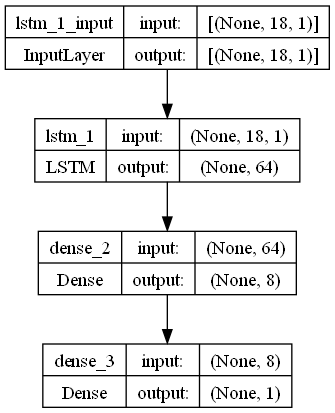

In [43]:
plot_model(m, f"LSTM_for_Inflation_Rate_Chile.png", show_shapes = True)

In [44]:
m.save(f"LSTM_for_Inflation_Rate_Chile.h5")